In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from joblib import dump, load
from skimage import io, color
from skimage.transform import resize
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Get the directory path
train_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train_ims"
test_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test_ims"

# List filenames in alphabetical order
train_filenames = sorted(os.listdir(train_directory_path))
test_filenames  = sorted(os.listdir(test_directory_path))

In [2]:
x_train = []
x_test = []

train_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train.csv") #change path
test_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test.csv") #change path

for i in range(50000): 
    image = io.imread(f"{train_directory_path}/{train_filenames[i]}")
    x_train.append(image)



for j in range(10000): 
    image = io.imread(f"{test_directory_path}/{test_filenames[j]}")
    x_test.append(image)

y_train = np.array(train_df["label"].to_numpy())
y_test = np.array(test_df["label"].to_numpy())

x_train = np.array(x_train)
x_test = np.array(x_test)

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)


In [3]:
def get_sift_feature(im):
    gray_im = color.rgb2gray(im)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute((gray_im * 255).astype("uint8"), None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0) 

def get_hog_feature(im, Orien, PPC ,CPB):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) / 255
    hog_features = hog(gray_im, orientations=Orien, pixels_per_cell=PPC, cells_per_block=CPB)
    #uncomment line below for normalization
    hog_features = hog_features/np.sum(np.abs(hog_features))

    hsv_image = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    
    hist_features = []
    for channel in cv2.split(hsv_image):
        hist_features.append(cv2.calcHist([channel], [0], None, [8], [0, 256]))

    hist_features = np.concatenate(hist_features).flatten() / (image.shape[0] * image.shape[1])

    merged_features = np.concatenate((hog_features, hist_features))

    return(merged_features)


In [4]:
'''
sift_features_train = []
sift_features_test = []

for image1 in x_train:
    sift_features_train.append(get_sift_feature(image1)) #checking for sift feature 

for image2 in x_test:
    sift_features_test.append(get_sift_feature(image2)) #checking for sift feature 

sift_features_train = np.array(sift_features_train)
sift_features_test = np.array(sift_features_test)
'''

'\nsift_features_train = []\nsift_features_test = []\n\nfor image1 in x_train:\n    sift_features_train.append(get_sift_feature(image1)) #checking for sift feature \n\nfor image2 in x_test:\n    sift_features_test.append(get_sift_feature(image2)) #checking for sift feature \n\nsift_features_train = np.array(sift_features_train)\nsift_features_test = np.array(sift_features_test)\n'

In [4]:
hog_features_train = []
hog_features_test = []

for image3 in x_train:
    hog_features_train.append(get_hog_feature(image3,6,(2,2),(1,1))) #checking for hog feature 

for image4 in x_test:
    hog_features_test.append(get_hog_feature(image4,6,(2,2),(1,1))) #checking for hog feature 

hog_features_train = np.array(hog_features_train)
hog_features_test = np.array(hog_features_test)


In [5]:
pca1 = PCA(0.9)
pca1.fit(hog_features_train)
print(pca1.n_components_)


10


In [6]:
from sklearn.model_selection import train_test_split

X_internal_train, X_internal_test, y_internal_train, y_internal_test = train_test_split(hog_features_train, y_train, test_size=0.2, random_state=42)

pipe = Pipeline([('StandardScaler', MinMaxScaler()), ('pca', PCA(0.9)), ('rbfsvc', SVC(kernel='rbf', C=5, gamma = 0.5, cache_size=10000))])

#pipe = Pipeline([('StandardScaler', MinMaxScaler()), ('pca', PCA(n_components=64)), ('rbfsvc', SVC(kernel='rbf', C=1.5, gamma = 0.14, cache_size=10000))])

pipe.fit(X_internal_train, y_internal_train)

#pipe.fit(sift_features_train, y_train)

Pipeline(steps=[('StandardScaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.9)),
                ('rbfsvc', SVC(C=5, cache_size=10000, gamma=0.5))])

In [7]:
#get accuracy
from sklearn.metrics import accuracy_score

y_pred = pipe.predict(X_internal_test)
accuracy = accuracy_score(y_internal_test, y_pred)
print(accuracy)


0.0966


In [ ]:

y_pred = pipe.predict(hog_features_test)


#test_df["label"] = y_pred
#test_df.to_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/rishi_work/rishi_test4.csv", index=False)

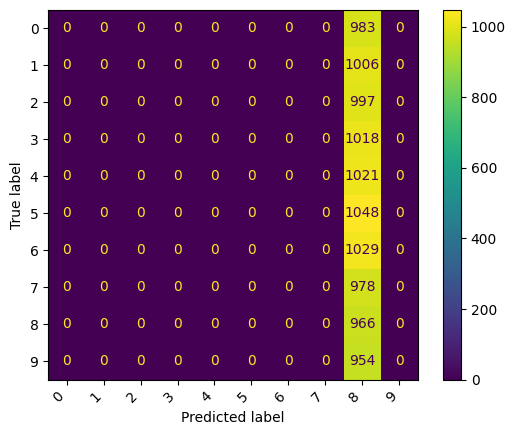

In [8]:
color = 'white'
cm = confusion_matrix(y_internal_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()